# 신발 추천 서비스 : JordanRecommend

## 전체 프로세스

- df -> execute_kmeans_by_default_k -> cluster_col_added_df -> show_samples_by_transformed_df -> select -> transform_corresponding_cluster_df -> silhouette -> optimal k return -> execute_kmeans_by_optimal_k -> new_cluster_col_added_df -> show_samples_by_transformed_df ( if 문 )-> select... 반복

In [3]:
import pandas as pd
import pickle
pd.read_csv('img_url3.csv')

,_id,model_no,img_url
0,Jordan 1 Low Vintage Grey,553558-053,https://kream-phinf.pstatic.net/MjAyMjA2MjdfMT...
1,Jordan 1 x Travis Scott x Fragment Retro Low O...,DM7866-140,https://kream-phinf.pstatic.net/MjAyMTA3MzBfNT...
2,Jordan 1 Retro High OG Black Mocha,555088-105,https://kream-phinf.pstatic.net/MjAyMDEwMjJfOC...
3,Jordan 4 Retro White and Black,DH6927-111,https://kream-phinf.pstatic.net/MjAyMjA1MDlfOD...
4,Jordan 1 Retro High OG Bleached Coral,555088-108,https://kream-phinf.pstatic.net/MjAyMjA1MDlfMT...
...,...,...,...
2988,Jordan 1 Retro High OG SP Gina (Special Box),CD7071-001,https://kream-phinf.pstatic.net/MjAyMTAyMjJfMS...
2989,Jordan 13 Retro Low Quai 54,810551-050,https://kream-phinf.pstatic.net/MjAyMDEwMjJfMj...
2990,(GS) Jordan 11 Retro Heiress Velvet,852625-650,https://kream-phinf.pstatic.net/MjAyMDEwMjJfND...
2991,Jordan 1 Retro High Flyknit Derek Jeter RE2PECT,AH7233-105,https://kream-phinf.pstatic.net/MjAyMDEwMjJfNT...


In [26]:
import pandas as pd
import pickle

with open("embedding_dict.pkl","rb") as f:
    embedding_dict = pickle.load(f)
df1 = pd.DataFrame(embedding_dict).T.reset_index()
df1

,index,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,130207-061,0.000000,1.888332,0.172100,4.068963,0.104849,0.303489,0.046266,0.331634,1.679887,...,0.766138,0.443566,0.086086,0.659108,1.206932,1.750699,0.018331,0.009301,0.000000,0.057214
1,130207-101,0.349783,0.356310,0.235518,2.617073,0.122327,0.002715,0.954131,2.434871,1.465651,...,0.142416,0.849017,0.003008,0.108854,0.447678,0.165827,0.000000,0.036120,0.281205,0.155948
2,130245-062,0.963042,0.367914,0.153923,1.360493,0.337997,0.245594,0.176222,0.004455,2.110016,...,0.586292,0.582415,0.090245,0.711076,0.397174,0.359469,0.001991,0.009999,0.025743,0.267511
3,136002-061,0.050678,0.609021,0.168990,0.946096,0.764102,0.098693,0.065163,0.464963,0.755447,...,0.495370,0.017183,0.043893,0.179883,0.740535,0.037135,0.004999,0.030384,0.404947,0.576160
4,136002-132,0.021144,0.785872,0.184058,1.524752,0.083327,0.248589,0.008811,3.770092,1.979329,...,0.416061,0.411912,0.019130,0.752148,0.484757,1.295632,0.000981,0.008091,0.003341,0.492337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2988,DV3528-102,0.429011,0.307042,0.017807,2.544183,1.129875,0.132798,0.174601,1.462012,0.030095,...,0.560554,0.979046,0.004755,1.719512,2.298285,0.114149,0.000000,0.354896,0.001004,1.286503
2989,DV3529-102,0.542442,0.287423,0.101110,2.189429,0.163303,0.399271,0.211046,1.732060,0.017048,...,0.830916,0.656179,0.155236,1.158641,2.522303,0.079398,0.000000,0.851832,0.016930,1.105025
2990,DV3605-410,0.001898,0.114387,0.255131,2.436839,0.764894,0.379462,0.977180,1.272713,0.398370,...,0.312702,0.524417,0.611555,0.819275,1.756852,0.226599,0.014955,0.480263,0.616476,2.764617
2991,DX4446-301,0.140962,0.546311,0.594014,2.650371,0.174703,0.003632,1.318144,0.608453,0.128094,...,0.020645,0.396722,0.008012,0.278900,1.641260,1.743138,0.000000,0.007873,0.131962,0.226099


In [50]:
df2 = pd.read_csv('img_url3.csv')
df2['model_no'] = df2['model_no'].str.replace('/',' ').str.strip()
df2 = df2.drop(columns=['_id','img_url'])
df2['file_path'] = './image_224/'+df2["model_no"].str[:]+'.png'
df2['model_code'] = df2['model_no']
df2

,model_no,file_path,model_code
0,553558-053,./image_224/553558-053.png,553558-053
1,DM7866-140,./image_224/DM7866-140.png,DM7866-140
2,555088-105,./image_224/555088-105.png,555088-105
3,DH6927-111,./image_224/DH6927-111.png,DH6927-111
4,555088-108,./image_224/555088-108.png,555088-108
...,...,...,...
2988,CD7071-001,./image_224/CD7071-001.png,CD7071-001
2989,810551-050,./image_224/810551-050.png,810551-050
2990,852625-650,./image_224/852625-650.png,852625-650
2991,AH7233-105,./image_224/AH7233-105.png,AH7233-105


In [51]:
df3 = df2.merge(df1,how='inner',left_on="model_no",right_on="index")
df3 = df3.drop(columns='index')
df3.to_csv('csv_for_JR.csv')
df3

import pickle
with open("jordan_embedding_dict_df.pkl",'wb') as f:
    pickle.dump(df3,f)

In [10]:
df5 = pd.read_csv('csv_for_JR.csv')
df5.loc[0,"0":"511"].tolist()

[0.026308777,
 0.44611216,
 0.02244107,
 1.6650687,
 0.35516432,
 0.14477389,
 1.4074297,
 1.5125792,
 0.20548746,
 0.024437238,
 0.443121,
 0.0,
 0.3931166,
 0.50247324,
 0.35301512,
 1.4546108,
 2.5580258,
 0.8690794,
 2.0117397,
 0.77349657,
 0.27434403,
 0.7190094,
 0.0,
 0.24131967,
 2.1127372,
 0.65183765,
 0.03502954,
 0.54647005,
 1.3993051,
 0.1350132,
 0.91456574,
 1.4354963,
 2.4337463,
 0.2335972,
 0.023388619,
 4.168136,
 0.17778395,
 3.8215902,
 0.11655092,
 0.14076841,
 0.043989338,
 0.9425778,
 0.48488525,
 0.57235277,
 0.88410187,
 0.45382982,
 0.7853846,
 1.2993934,
 0.038063634,
 0.065303825,
 3.0866811,
 0.19732995,
 0.73429614,
 1.6447939,
 0.0,
 1.9443507,
 0.1552157,
 0.17108732,
 0.14747113,
 2.2592485,
 1.4979506,
 2.1194634,
 0.2653963,
 0.054246932,
 1.7859752,
 0.105883025,
 4.1590943,
 0.63084877,
 0.034744952,
 0.5583292,
 0.0037456967,
 0.2667854,
 0.024070099,
 0.046347216,
 0.04891755,
 0.03501844,
 0.2063533,
 0.052488,
 0.35490662,
 0.0,
 0.27556223,


In [22]:
import pickle

with open("jordan_embedding_dict_df.pkl","rb") as f:
    df = pickle.load(f)
df

,model_no,file_path,model_code,0,1,2,3,4,5,6,...,502,503,504,505,506,507,508,509,510,511
0,553558-053,./image_224/553558-053.png,553558-053,0.026309,0.446112,0.022441,1.665069,0.355164,0.144774,1.407430,...,0.030451,0.417743,0.194275,0.258652,1.559767,0.127391,0.000000,0.008930,0.165795,0.014965
1,DM7866-140,./image_224/DM7866-140.png,DM7866-140,0.023389,0.002546,0.070857,1.287806,0.055228,0.225909,0.670382,...,0.738315,1.002537,0.152530,0.066414,2.004650,1.125030,0.000000,0.080334,0.151629,0.101394
2,555088-105,./image_224/555088-105.png,555088-105,0.004161,0.074477,0.544856,1.673943,0.251016,0.020887,1.004260,...,0.358522,0.425758,0.008596,0.454090,0.769909,0.546023,0.000000,0.032915,0.107209,1.022224
3,DH6927-111,./image_224/DH6927-111.png,DH6927-111,0.692499,1.410187,0.445121,2.663520,0.498345,0.282219,1.345795,...,0.592597,0.301277,0.816238,0.165051,0.383379,0.784562,0.121596,0.000000,0.276481,1.744524
4,555088-108,./image_224/555088-108.png,555088-108,0.393879,0.517403,0.992474,3.637862,0.340433,0.027730,1.791372,...,0.037359,0.098551,0.091971,0.516889,0.133902,1.154353,0.004665,0.000000,0.044736,0.797515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2988,CD7071-001,./image_224/CD7071-001.png,CD7071-001,0.293715,1.417441,0.174254,0.029442,0.079922,0.200246,0.003974,...,0.724916,0.383581,0.021155,0.082321,1.888880,0.509080,0.007205,0.014406,0.000178,0.000000
2989,810551-050,./image_224/810551-050.png,810551-050,1.487948,0.992507,0.144529,0.004882,0.317066,0.414079,0.020820,...,1.399022,0.047412,0.099896,0.080328,0.858762,1.160617,0.010359,0.003236,0.093413,0.007161
2990,852625-650,./image_224/852625-650.png,852625-650,0.664668,0.681816,0.093948,2.271096,0.343624,0.213577,0.000000,...,0.703582,0.165587,0.052237,1.422426,2.205470,1.258458,0.003407,0.065258,0.153471,1.007956
2991,AH7233-105,./image_224/AH7233-105.png,AH7233-105,0.576534,0.610457,0.747367,1.387222,1.859859,0.066439,0.723445,...,0.034282,1.423089,0.108783,0.190838,0.727266,0.028120,0.000418,0.085302,0.221600,0.003892


In [12]:
class JordanRecommend:
    
    
    
    def __init__(self,k_num=8,opt=False, random_state=42):
        
#         print('__init__ 실행')

        import pandas as pd
        import pickle
        from sklearn.cluster import KMeans
        

        # 피클에서 df 불러오기
        with open("jordan_embedding_dict_df.pkl","rb") as f:
            self.__df = pickle.load(f)
            
        # 변하지 않는 멤버 변수 초기화 
        self.df = self.__df.loc[:,0:511] # 임베딩 벡터 
        self.df_ = self.__df.loc[:,['model_code','file_path']] # 모델 이름, 이미지파일 위치
        
        # 변하는 멤버변수 초기화
        self.dfm = self.df.copy()
        self.df_m = self.df_.copy()
        
        # k_num, opt, random_state 초기화
        self.opt = opt
        self.random_state = random_state

#         if self.opt == True:
#             self.silhouette()
#         else:
#             self.k_num = k_num
        self.k_num = k_num
    
    
        
        # kmean 초기화
        self.kmeans = KMeans(n_clusters=self.k_num, random_state=self.random_state,verbose=0)
        self.labels = self.kmeans.fit_predict(self.dfm)
        self.df_m['cluster'] = self.labels # df_m 의 컬럼 ['index', 'model_code','file_path', 'cluster']
        
        
        self.show_samples(self.dfm, self.df_m)
        
        
        
    def show_samples(self,dfm,df_m):
#         print('show_samples 실행')
        import matplotlib.pyplot as plt
        from PIL import Image
        import random
        
        print('현재 k_num : '+str(self.k_num))
        print('현재 df_m 개수 : '+str(len(self.df_m)))
        
        self.dfm = dfm
        self.df_m = df_m
        
        # 현재 k_num 을 바탕으로 현재 df_m 에 존재하는 클러스터 별 샘플 그리기
        
        if self.k_num < len(self.df_m):

            fig, ax = plt.subplots(1,self.k_num)
            fig.set_size_inches(20,2)
            
            for i in range(self.k_num): # 여기 위치에서는 k_num 과 cluster 수가 같아야한다.

                df = self.return_cluster_num_df(i+1) # for 문 i 에 따라 df가 변경

                img_loc = df.file_path.tolist()
                random.shuffle(img_loc)
                ax[i].axis('off')
                ax[i].set_title(f'{i+1}')
                img = Image.open(img_loc[0])
                ax[i].imshow(img)

            plt.show()
            
            self.recommend()
        
        
        
        else: # self.k_num >= len(self.df_m) 일 때
            print('************************here is my recommend************************')

            fig, ax = plt.subplots(1,len(self.df_m))
            fig.set_size_inches(20,2)
            
            if len(self.df_m) ==1: # ax가 1개 이므로 ax[1] 라 표현하면 not subscriptable error 발생
                for j,k in zip(self.df_m['file_path'], self.df_m['model_code']):

                    ax.axis('off')
                    ax.set_title(k)
                    img = Image.open(j)
                    ax.imshow(img)

                plt.show()

            else:
                
                for i,j,k in zip(range(len(self.df_m)), self.df_m['file_path'], self.df_m['model_code']):

                    ax[i].axis('off')
                    ax[i].set_title(k)
                    img = Image.open(j)
                    ax[i].imshow(img)

                plt.show()
                
            print('\n********************************************************************\n')

            return 0


            
            
            
    def recommend(self):
#         print('recommend 실행')
        self.input1 = input('Enter the "number" of your most preferred sample or Type "re" to resuffle & show => input : ')
        print('현재 k_num : '+str(self.k_num))
        try:

            if int(self.input1) <= self.k_num:
                self.select(int(self.input1))

            else:
                print("\n\n*****************************************************************************")
                print("************************Please enter a number under "+str(self.k_num)+"************************")
                print("*****************************************************************************\n\n")

                self.recommend()


        except:
            
            if self.input1 == 're':
                print('\n\n***********************************************************')
                print('************************reshuffling************************')
                print('***********************************************************\n\n')
                self.show_samples(self.dfm,self.df_m)
                self.recommend()

            else:
                print('\n\n************************************************************************')
                print('************************Please enter it correctly************************')
                print('************************************************************************\n\n')
                self.recommend()



    def select(self,num):
        
#         print('select 실행')
        import matplotlib.pyplot as plt
        from PIL import Image
        import random
        from sklearn.cluster import KMeans



        self.silhouette() # opt = True일 때 self.k_num 을 최적으로 결정

        if self.k_num > len(self.df_m):
            self.show_samples(self.dfm, self.df_m)
        else:
            
            self.df_m = self.return_cluster_num_df(num)
            self.dfm = self.df.loc[self.df_m.index]
            
            
            if self.k_num > len(self.df_m):
                self.show_samples(self.dfm, self.df_m)

            else:
                self.kmeans = KMeans(n_clusters=self.k_num, random_state=self.random_state,verbose=0)
                self.labels = self.kmeans.fit_predict(self.dfm)
                self.df_m = self.df_m.drop(columns=['cluster'])
                self.df_m['cluster'] = self.labels
                self.dfm = self.df.loc[self.df_m.index]

                self.show_samples(self.dfm, self.df_m)


        
        
    def return_cluster_num_df(self,num): # num에 해당하는 클러스터 df를 반환하는 함수 
        
        return self.df_m[self.df_m['cluster']==num-1] # -1 의미 : 클러스터가 0부터 표현되기 때문
        

        
    def silhouette(self):

        import copy
        import numpy as np
        
        
        if self.opt==True:
        
            from sklearn.cluster import KMeans
            from sklearn.metrics import silhouette_samples, silhouette_score
            import pandas as pd
            import copy
            average_score_dict = dict()

            try:
                print('최적의 분류를 위해 silhouette 계수를 계산중입니다. 잠시만 기다려주세요')
                for i in range(4,10):

                    df0 = copy.deepcopy(self.dfm)
                    kmeans = KMeans(n_clusters= i,random_state=self.random_state,verbose=0)
                    labels = kmeans.fit_predict(df0.loc[:,0:511])
                    df0['cluster'] = labels

                    # 모든 데이터의 평균 실루엣 계수값을 구함. 
                    average_score = silhouette_score(df0.loc[:,0:511], labels)
                    average_score_dict[f'{i}'] = average_score

                self.k_num = np.array(list(average_score_dict.values())).argmax()+4
                print('실루엣 후 k_num = ' +str(self.k_num))
            except:
                pass

        else:
            pass
        

In [13]:
# 서비스 시작을 위해 아래의 코드를 실행해주세요

현재 k_num : 6
현재 df_m 개수 : 2993


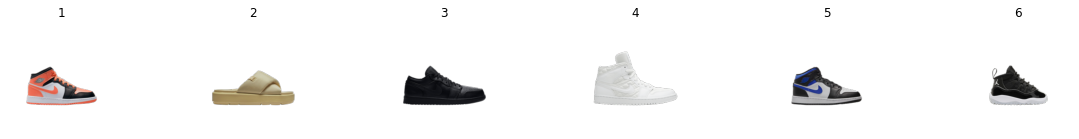

Enter the "number" of your most preferred sample or Type "re" to resuffle & show => input : re
현재 k_num : 6


***********************************************************
************************reshuffling************************
***********************************************************


현재 k_num : 6
현재 df_m 개수 : 2993


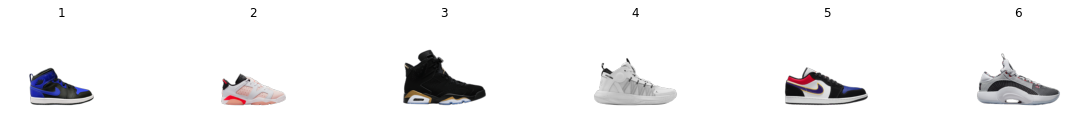

Enter the "number" of your most preferred sample or Type "re" to resuffle & show => input : re
현재 k_num : 6


***********************************************************
************************reshuffling************************
***********************************************************


현재 k_num : 6
현재 df_m 개수 : 2993


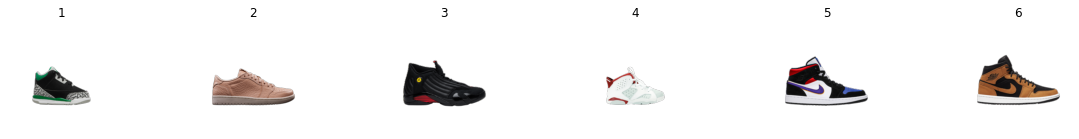

Enter the "number" of your most preferred sample or Type "re" to resuffle & show => input : re
현재 k_num : 6


***********************************************************
************************reshuffling************************
***********************************************************


현재 k_num : 6
현재 df_m 개수 : 2993


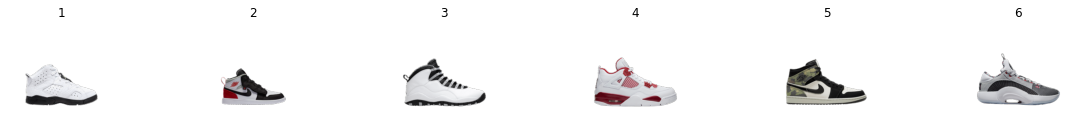

Enter the "number" of your most preferred sample or Type "re" to resuffle & show => input : re
현재 k_num : 6


***********************************************************
************************reshuffling************************
***********************************************************


현재 k_num : 6
현재 df_m 개수 : 2993


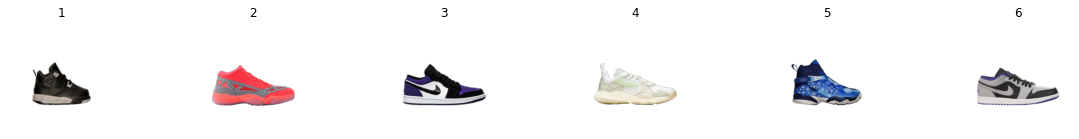

Enter the "number" of your most preferred sample or Type "re" to resuffle & show => input : re
현재 k_num : 6


***********************************************************
************************reshuffling************************
***********************************************************


현재 k_num : 6
현재 df_m 개수 : 2993


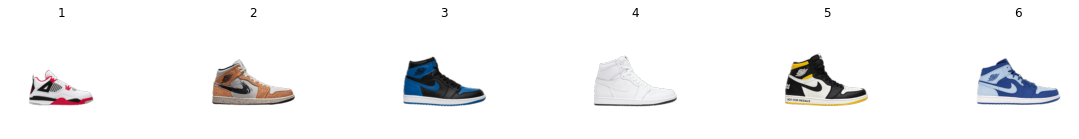

Enter the "number" of your most preferred sample or Type "re" to resuffle & show => input : 4
현재 k_num : 6
최적의 분류를 위해 silhouette 계수를 계산중입니다. 잠시만 기다려주세요
실루엣 후 k_num = 5
현재 k_num : 5
현재 df_m 개수 : 491


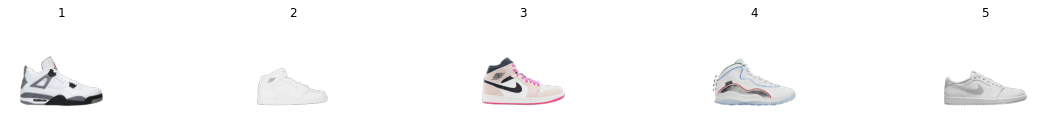

Enter the "number" of your most preferred sample or Type "re" to resuffle & show => input : 5
현재 k_num : 5
최적의 분류를 위해 silhouette 계수를 계산중입니다. 잠시만 기다려주세요
실루엣 후 k_num = 8
현재 k_num : 8
현재 df_m 개수 : 121


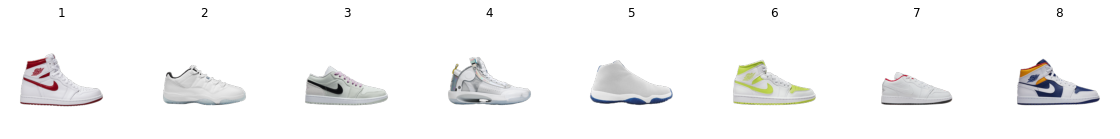

Enter the "number" of your most preferred sample or Type "re" to resuffle & show => input : 2
현재 k_num : 8
최적의 분류를 위해 silhouette 계수를 계산중입니다. 잠시만 기다려주세요
실루엣 후 k_num = 6
현재 k_num : 6
현재 df_m 개수 : 24


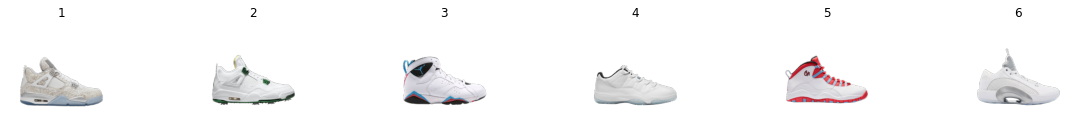

Enter the "number" of your most preferred sample or Type "re" to resuffle & show => input : 4
현재 k_num : 6
최적의 분류를 위해 silhouette 계수를 계산중입니다. 잠시만 기다려주세요
실루엣 후 k_num = 4
현재 k_num : 4
현재 df_m 개수 : 2
************************here is my recommend************************


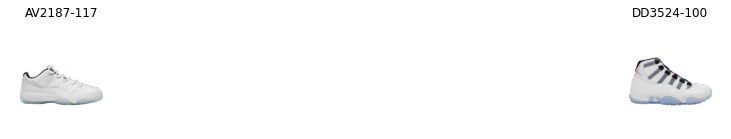


********************************************************************



KeyboardInterrupt: Interrupted by user

In [21]:
JordanRecommend(k_num=6,opt=True,random_state=50) # opt=True 일 때 k_num 은 무시됨, k_num=8 random_state=42 opt =False 이 default